In [3]:
from collections import Counter
import json
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm

In [4]:
annotations_path = "./annotations/"
annotations = os.listdir(annotations_path)
annotations = [file for file in annotations if file.endswith(".vcf")]

In [5]:
df = pd.DataFrame()

for annotation in tqdm(annotations):
    
    data = []

    with open(f"annotations/{annotation}", "r") as f:
        for line in f.readlines():
                data.append(line.strip().split("\t"))

    column_names = data[0]
    data = data[1:]
                
    df_tmp = pd.DataFrame(data, columns=column_names)
    
    df_tmp["ID_WGS"] = annotation.split(".")[0].split("_")[-1]
    df_tmp = df_tmp[["ID_WGS", "Chromosome", "Start", "End", "Type", "Classification", "All protein coding genes"]]
    df_tmp.rename(columns={"All protein coding genes": "Protein_coding_genes"}, inplace=True)
    df_tmp.dropna(subset=["Protein_coding_genes"], inplace=True)
    
    df = pd.concat([df, df_tmp], axis=0)

df = df.reset_index(drop=True)
# df.to_csv("results/all_annotated_cnv.csv", index=False)

  0%|          | 0/387 [00:00<?, ?it/s]

100%|██████████| 387/387 [00:05<00:00, 74.42it/s]


In [7]:
df_pheno = pd.read_csv("data/phenotype_WGS.csv")
df_pheno.rename(columns={"Snumber": "ID_WGS"}, inplace=True)
df_pheno

,ID_WGS,UID,Code,Conversion_Psychosis,Phenotype
0,S36739,IC01001,UHR,C,Converter
1,S36740,IC01004,SCZ,NaN,FEP
2,S36741,IC01006,UHR,NaN,UHR
3,S36742,IC01010,UHR,C,Converter
4,S36743,IC01012,UHR,NC,Non_converter
...,...,...,...,...,...
395,S36989,STR01-032-MM-I,UHR,NC,Non_converter
396,S36990,STR01-033-CE-I,UHR,C,Converter
397,S36991,STR01-034-MT-I,UHR,C,Converter
398,S36992,STR01-039-DL-I,UHR,NC,Non_converter


In [12]:
print("No genetic data for:", end=" ")

for id in df_pheno["ID_WGS"].to_list():
    if id not in df["ID_WGS"].to_list():
        print(id, end=", ")

No genetic data for: S36739, S36740, S36741, S36746, S36751, S36797, S36807, S36809, S36848, S36997, S36944, S37071, S37088, 

In [8]:
df_pathogen = df[(df["Classification"] == "Pathogenic") | (df["Classification"] == "Likely pathogenic")]

for id in df_pathogen["ID_WGS"]:
    pathogen_index = df_pathogen["ID_WGS"] == id
    pheno_index = df_pheno["ID_WGS"] == id
    df_pathogen.loc[pathogen_index, "Code"] = df_pheno.loc[pheno_index, "Code"].values[0]
    df_pathogen.loc[pathogen_index, "Phenotype"] = df_pheno.loc[pheno_index, "Phenotype"].values[0]

df_pathogen = df_pathogen[["ID_WGS", "Code", "Phenotype", "Chromosome", "Start", "End", "Type", "Classification", "Protein_coding_genes"]]
df_pathogen.to_csv("results/pathogenic_cnv.csv", index=False)  
df_pathogen

/tmp/ipykernel_306/3927838187.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pathogen.loc[pathogen_index, "Code"] = df_pheno.loc[pheno_index, "Code"].values[0]
/tmp/ipykernel_306/3927838187.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'UHR' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_pathogen.loc[pathogen_index, "Code"] = df_pheno.loc[pheno_index, "Code"].values[0]
/tmp/ipykernel_306/3927838187.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

,ID_WGS,Code,Phenotype,Chromosome,Start,End,Type,Classification,Protein_coding_genes
222,S36747,UHR,Non_converter,chrX,6535213,8168775,DEL,Pathogenic,"PUDP, STS, VCX, PNPLA4"
1422,S36774,SCZ,FEP,chr22,18731658,21110696,DEL,Pathogenic,"LOC102724770, DGCR6, LOC102724788, PRODH, DGCR..."
2361,S36795,UHR,Converter,chr9,21959044,21974294,DEL,Likely pathogenic,CDKN2A
7519,S36908,SCZ,FEP,chr16,29599805,30187754,DEL,Pathogenic,"SPN, QPRT, C16orf54, ZG16, KIF22, MAZ, PRRT2, ..."
9994,S36961,SCZ,FEP,chr15,22650252,23122942,DEL,Pathogenic,"GOLGA6L7, NIPA1, NIPA2, CYFIP1, TUBGCP5"
11012,S36981,UHR,Non_converter,chr8,142414773,145076114,DUP,Likely pathogenic,"ADGRB1, ARC, JRK, PSCA, LY6K, THEM6, SLURP1, L..."
11056,S36981,UHR,Non_converter,chr8,93064965,104546553,DUP,Likely pathogenic,"FBXO43, POLR2K, SPAG1, RNF19A, ANKRD46, SNX31,..."
17778,S37126,FEP,FEP,chr16,29599805,30187754,DEL,Pathogenic,"SPN, QPRT, C16orf54, ZG16, KIF22, MAZ, PRRT2, ..."


In [9]:
set(df_pathogen["Protein_coding_genes"].values.tolist())

{'ADGRB1, ARC, JRK, PSCA, LY6K, THEM6, SLURP1, LYPD2, SLURP2, LYNX1-SLURP2, LYNX1, LY6D, GML, CYP11B1, CYP11B2, LY6E, LY6L, LY6H, GPIHBP1, ZFP41, GLI4, ZNF696, TOP1MT, RHPN1, MAFA, ZC3H3, GSDMD, MROH6, NAPRT, EEF1D, TIGD5, PYCR3, TSTA3, ZNF623, ZNF707, CCDC166, MAPK15, FAM83H, SCRIB, PUF60, NRBP2, EPPK1, PLEC, PARP10, GRINA, SPATC1, OPLAH, EXOSC4, GPAA1, CYC1, SHARPIN, MAF1, WDR97, HGH1, MROH1, BOP1, SCX, HSF1, DGAT1, SCRT1, TMEM249, FBXL6, SLC52A2, ADCK5, CPSF1, SLC39A4, VPS28, TONSL, CYHR1, KIFC2, FOXH1, PPP1R16A, GPT, MFSD3, RECQL4, LRRC14, LRRC24, C8orf82, ARHGAP39, ZNF251, ZNF34, RPL8, ZNF517, ZNF7, COMMD5, ZNF250, ZNF16, C8orf33',
 'CDKN2A',
 'FBXO43, POLR2K, SPAG1, RNF19A, ANKRD46, SNX31, PABPC1, YWHAZ, ZNF706, GRHL2, NCALD, RRM2B, UBR5, ODF1, KLF10, AZIN1, ATP6V1C1, BAALC, FZD6, CTHRC1, SLC25A32, DCAF13, RIMS2, DCSTAMP, DPYS, LRP12, CIBAR1, RBM12B, TMEM67, PDP1, CDH17, GEM, RAD54B, FSBP, VIRMA, ESRP1, DPY19L4, INTS8, CCNE2, TP53INP1, NDUFAF6, PLEKHF2, C8orf37, GDF6, UQCRB, MTER

In [14]:
for id in tqdm(df["ID_WGS"]):
    genes = []
    df_index = df["ID_WGS"] == id
    genes.extend(df.loc[df_index, "Protein_coding_genes"].to_list())
    
    df_pheno_index = df_pheno["ID_WGS"] == id
    df_pheno.loc[df_pheno_index, "Protein_coding_genes"] = ', '.join(genes)
    
df_pheno.to_csv("results/genes_and_phenotypes.csv", index=False)
df_pheno

  0%|          | 0/18402 [00:00<?, ?it/s]/tmp/ipykernel_306/1849754180.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'GPRIN2, MRGPRX1, OR9G1, OR9G9, OR52N5, OR52N1, GLYATL1B, PRH1, PRH1-TAS2R14, TAS2R43, CACNA1C, SLC16A7, HEATR4, ACOT1, SCAPER, PDXDC1, CES1, PDPR, MAP2K3, KCNJ18, CCL3L3, CCL3L1, CCL4L1, CCL4L2, KRTAP9-6, LOXHD1, ST8SIA5, PSG4, SIGLEC14, ZNF324B, ZNF324, GSTM1, LCE3C, LCE3B, NBPF1, CROCC, CFHR3, CFHR1, RHD, SIRPB1, TPTE, SESTD1, ALG1L2, MUC20, FRG2C, UGT2B10, FAM90A26, USP17L10, PCDHA1, PCDHA2, PCDHA3, PCDHA4, PCDHA5, PCDHA6, PCDHA7, PCDHA8, PCDHA9, PCDHA10, DUSP22, HLA-DRB5, CLPSL1, CLPS, RIMS1, ZAN, MUC3A, MUC12, TARP, ASMT' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_pheno.loc[df_pheno_index, "Protein_coding_genes"] = ', '.join(genes)
100%|██████████| 18402/18402 [00:28<00:00, 641.17it/s]


,ID_WGS,UID,Code,Conversion_Psychosis,Phenotype,Protein_coding_genes
0,S36739,IC01001,UHR,C,Converter,NaN
1,S36740,IC01004,SCZ,NaN,FEP,NaN
2,S36741,IC01006,UHR,NaN,UHR,NaN
3,S36742,IC01010,UHR,C,Converter,"GPRIN2, MRGPRX1, OR9G1, OR9G9, OR52N5, OR52N1,..."
4,S36743,IC01012,UHR,NC,Non_converter,"ANTXRL, GPRIN2, DLG5, POLR3A, RPS24, MRGPRX1, ..."
...,...,...,...,...,...,...
395,S36989,STR01-032-MM-I,UHR,NC,Non_converter,"FANK1, ANTXRL, GPRIN2, MCU, MRGPRX1, OR4C11, O..."
396,S36990,STR01-033-CE-I,UHR,C,Converter,"FANK1, GPRIN2, MRGPRX1, OR4C11, OR4P4, OR4S2, ..."
397,S36991,STR01-034-MT-I,UHR,C,Converter,"FANK1, GPRIN2, MRGPRX1, OR9G1, OR9G9, PRH1, PR..."
398,S36992,STR01-039-DL-I,UHR,NC,Non_converter,"FANK1, GPRIN2, PCDH15, SLC35F2, OR9G1, OR9G9, ..."


/home/nadia/miniconda3/envs/everything/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nadia/miniconda3/envs/everything/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nadia/miniconda3/envs/everything/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/home/nadia/miniconda3/envs/everything/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in 

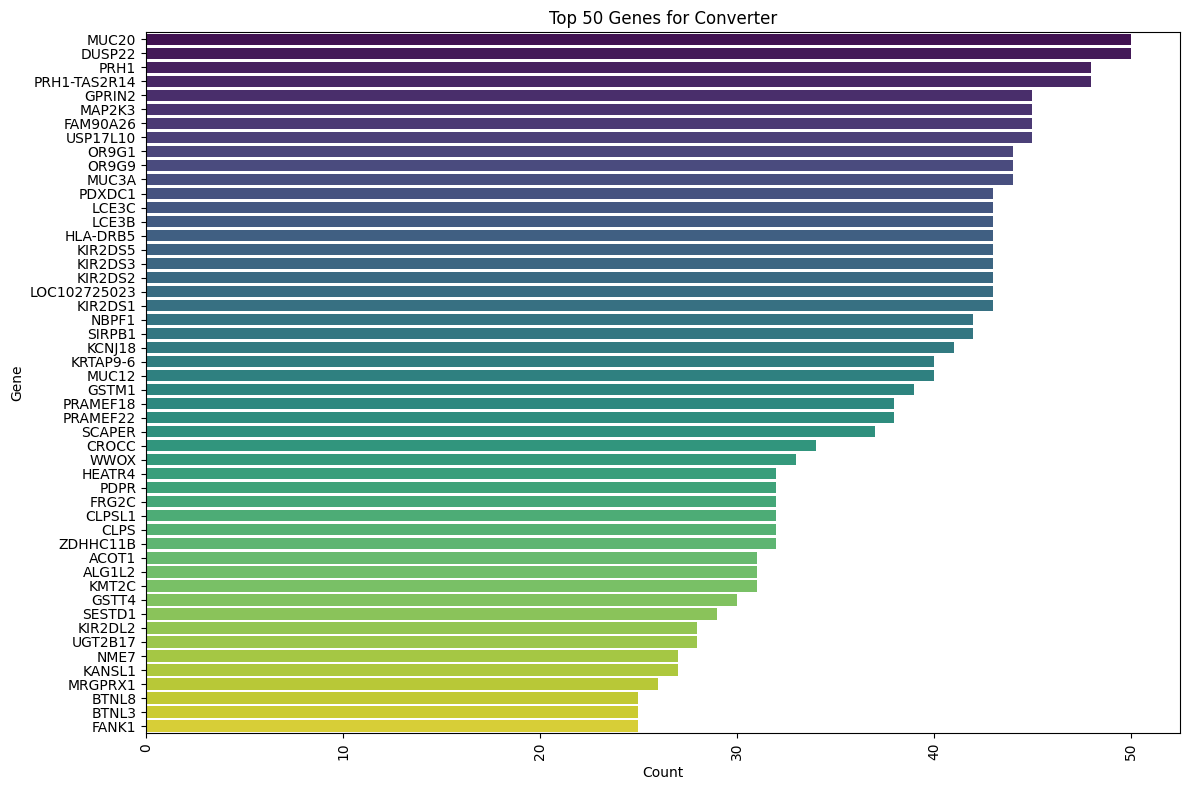

/home/nadia/miniconda3/envs/everything/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nadia/miniconda3/envs/everything/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nadia/miniconda3/envs/everything/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/home/nadia/miniconda3/envs/everything/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in 

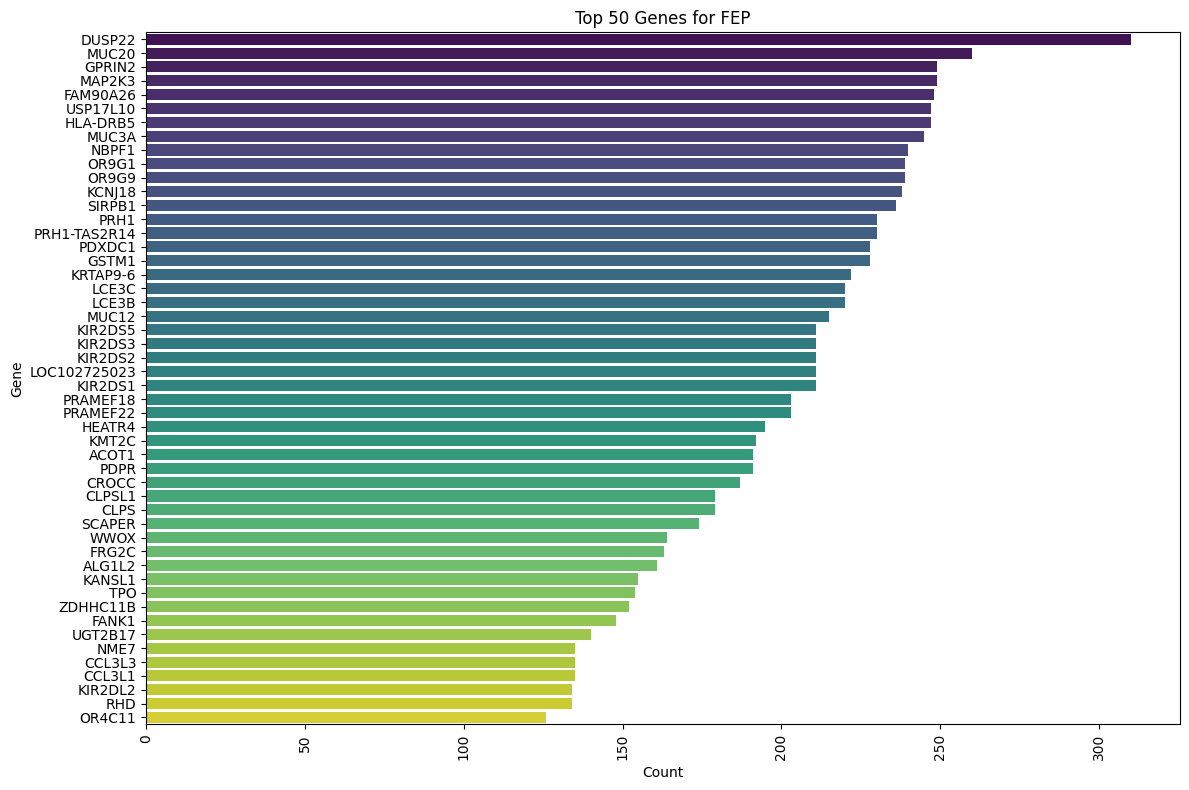

/home/nadia/miniconda3/envs/everything/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nadia/miniconda3/envs/everything/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nadia/miniconda3/envs/everything/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/home/nadia/miniconda3/envs/everything/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in 

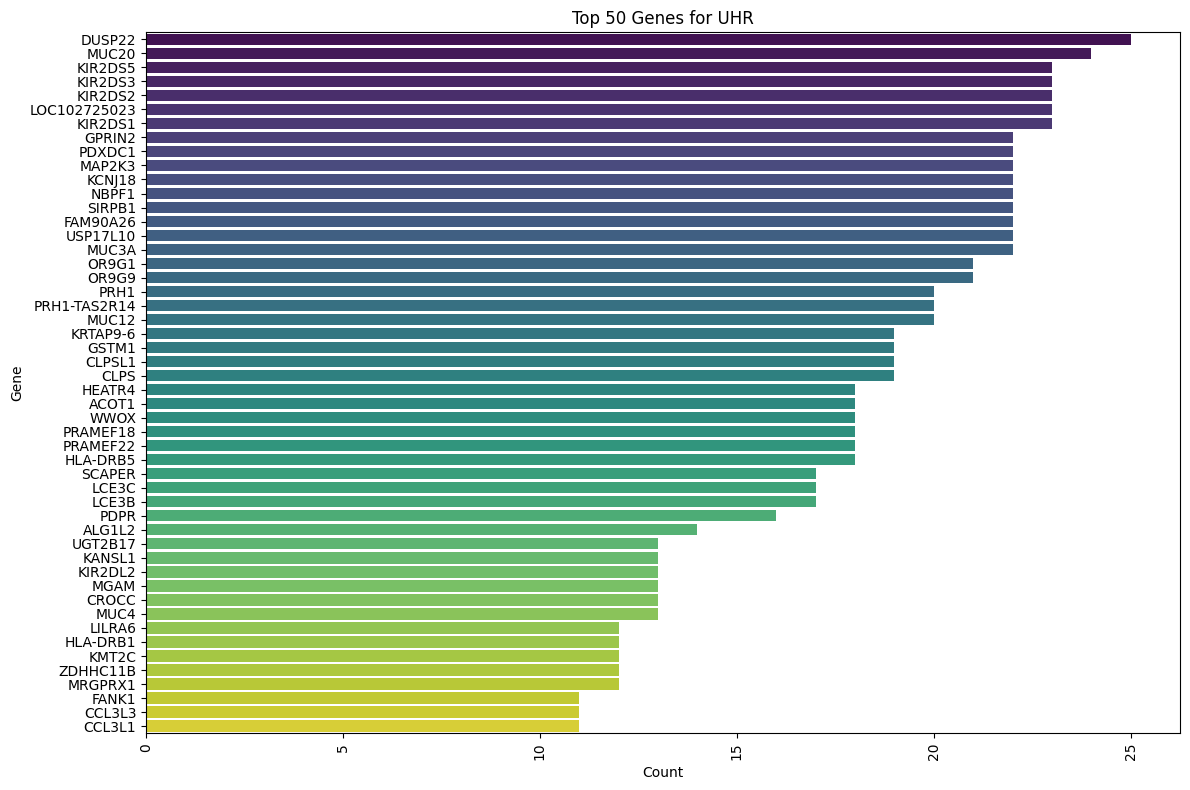

/home/nadia/miniconda3/envs/everything/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nadia/miniconda3/envs/everything/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nadia/miniconda3/envs/everything/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/home/nadia/miniconda3/envs/everything/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in 

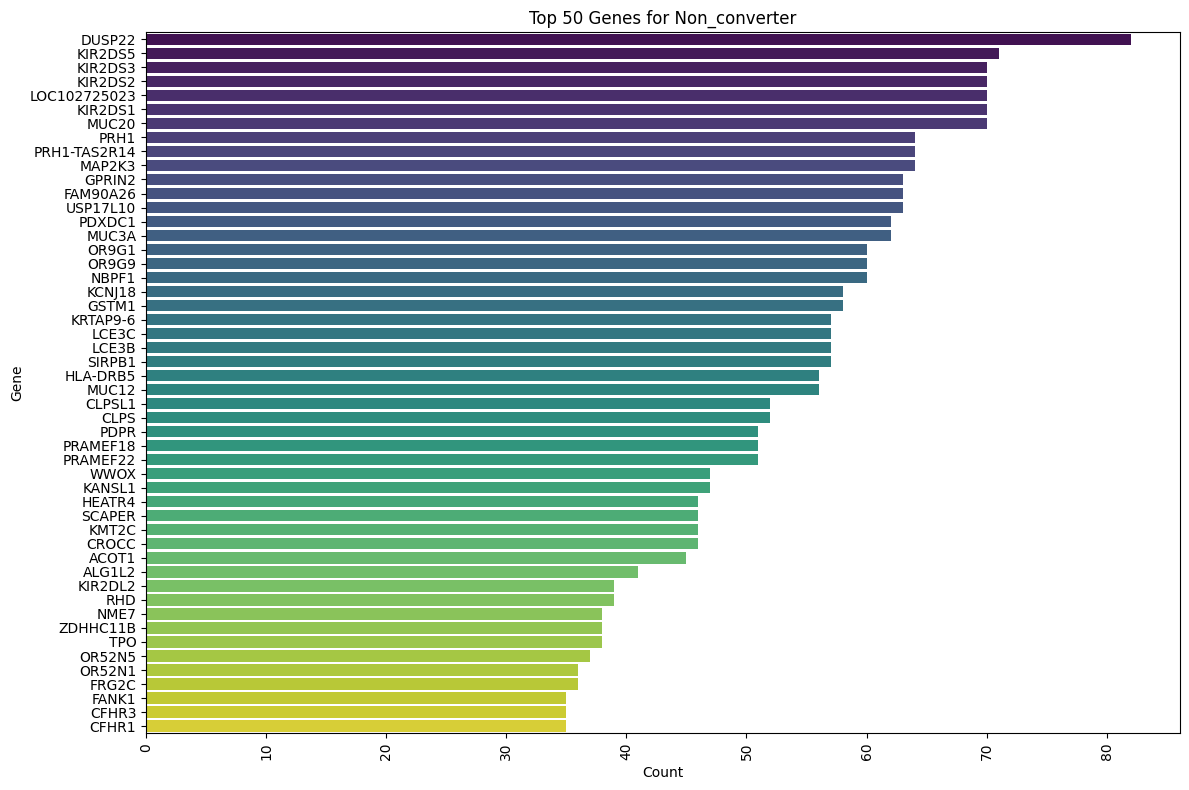

/home/nadia/miniconda3/envs/everything/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nadia/miniconda3/envs/everything/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/nadia/miniconda3/envs/everything/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/home/nadia/miniconda3/envs/everything/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in 

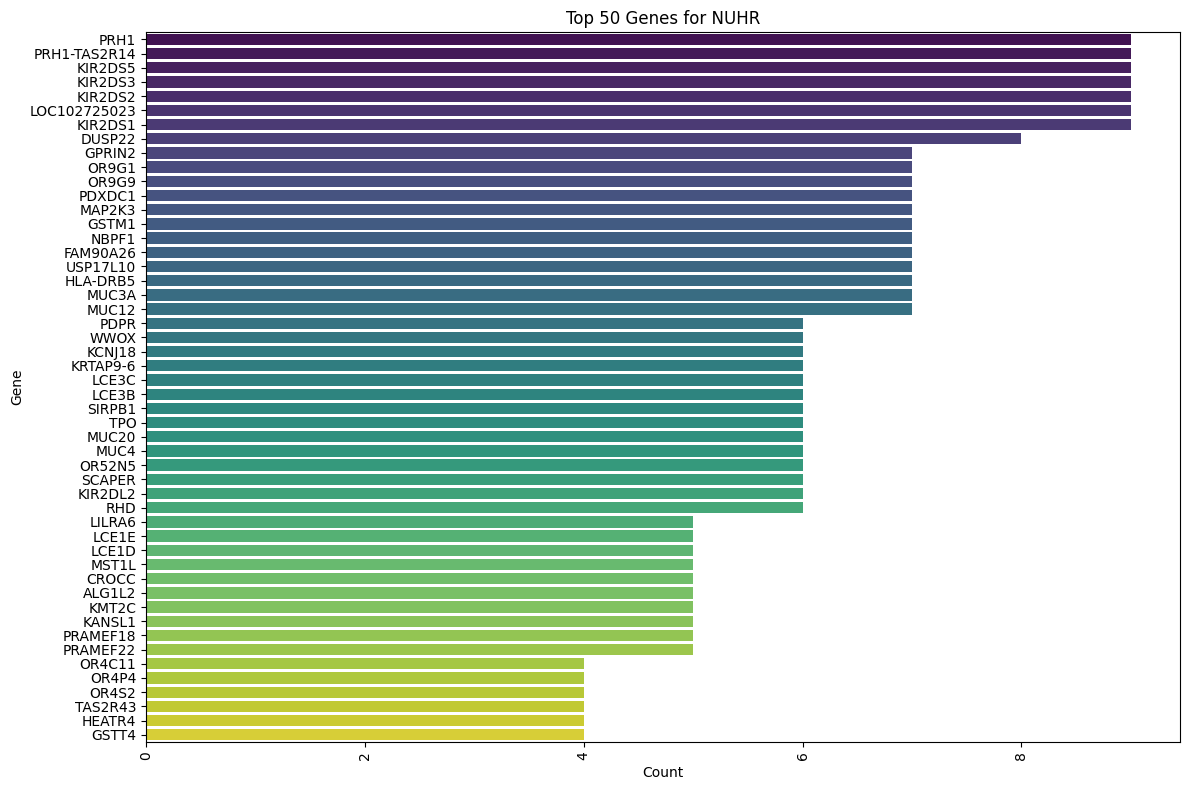

In [91]:
gene_counts_by_phenotype = {}

unique_phenotypes = df_pheno['Phenotype'].unique()[:-1]
for phenotype in unique_phenotypes:
    phenotype_df = df_pheno[df_pheno['Phenotype'] == phenotype]
    all_genes = [gene for genes_list in phenotype_df['Protein_coding_genes'] for gene in str(genes_list).split(', ')]
    gene_counts = Counter(all_genes)
    gene_counts_by_phenotype[phenotype] = gene_counts

top_N = 50

for phenotype, gene_counts in gene_counts_by_phenotype.items():
    top_genes = gene_counts.most_common(top_N)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x=[count for _, count in top_genes], y=[gene for gene, _ in top_genes], palette='viridis')
    plt.xlabel('Count')
    plt.ylabel('Gene')
    plt.title(f'Top {top_N} Genes for {phenotype}')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

In [96]:
with open("results/gene_counts_by_phenotype.json", "w") as f:
    json.dump(gene_counts_by_phenotype, f)

## Analyse statistique des genes entre les converteurs, non converteurs et uhr

In [16]:
df_pheno.dropna(subset=["Protein_coding_genes"], inplace=True)

In [42]:
genes = [genes.split(", ") for genes in df_pheno["Protein_coding_genes"]]
all_genes = list(set([gene for gene_list in genes for gene in gene_list]))
len(all_genes)

2437

In [44]:
converters = ["FEP", "Converter"]
non_converters = ["NUHR", "Non-converter"]
uhr = ["UHR"]

In [155]:
gene_freq_converters = {}
gene_freq_non_converters = {}
gene_freq_uhr = {}

for gene in all_genes:
    gene_freq_converters[gene] = 0
    gene_freq_non_converters[gene] = 0
    gene_freq_uhr[gene] = 0
    
for sujet in tqdm(df_pheno["ID_WGS"]):
    sujet_index = df_pheno["ID_WGS"] == sujet
    sujet_genes = df_pheno.loc[sujet_index, "Protein_coding_genes"].values[0].split(", ")
    sujet_phenotype = df_pheno.loc[sujet_index, "Phenotype"].values[0]
    
    if sujet_phenotype in converters:
        for gene in sujet_genes:
            gene_freq_converters[gene] += 1
    elif sujet_phenotype in non_converters:
        for gene in sujet_genes:
            gene_freq_non_converters[gene] += 1
    elif sujet_phenotype in uhr:
        for gene in sujet_genes:
            gene_freq_uhr[gene] += 1

100%|██████████| 387/387 [00:00<00:00, 2649.84it/s]


In [116]:
for gene in all_genes:
    gene_freq_converters[gene] /= sum(gene_freq_converters.values())
    gene_freq_non_converters[gene] /= sum(gene_freq_non_converters.values())
    gene_freq_uhr[gene] /= sum(gene_freq_uhr.values())

In [156]:
df_contig = pd.DataFrame({'converters': gene_freq_converters.values(), 
                   'non_converters': gene_freq_non_converters.values(), 
                   'uhr': gene_freq_uhr.values()}, index=gene_freq_uhr.keys())


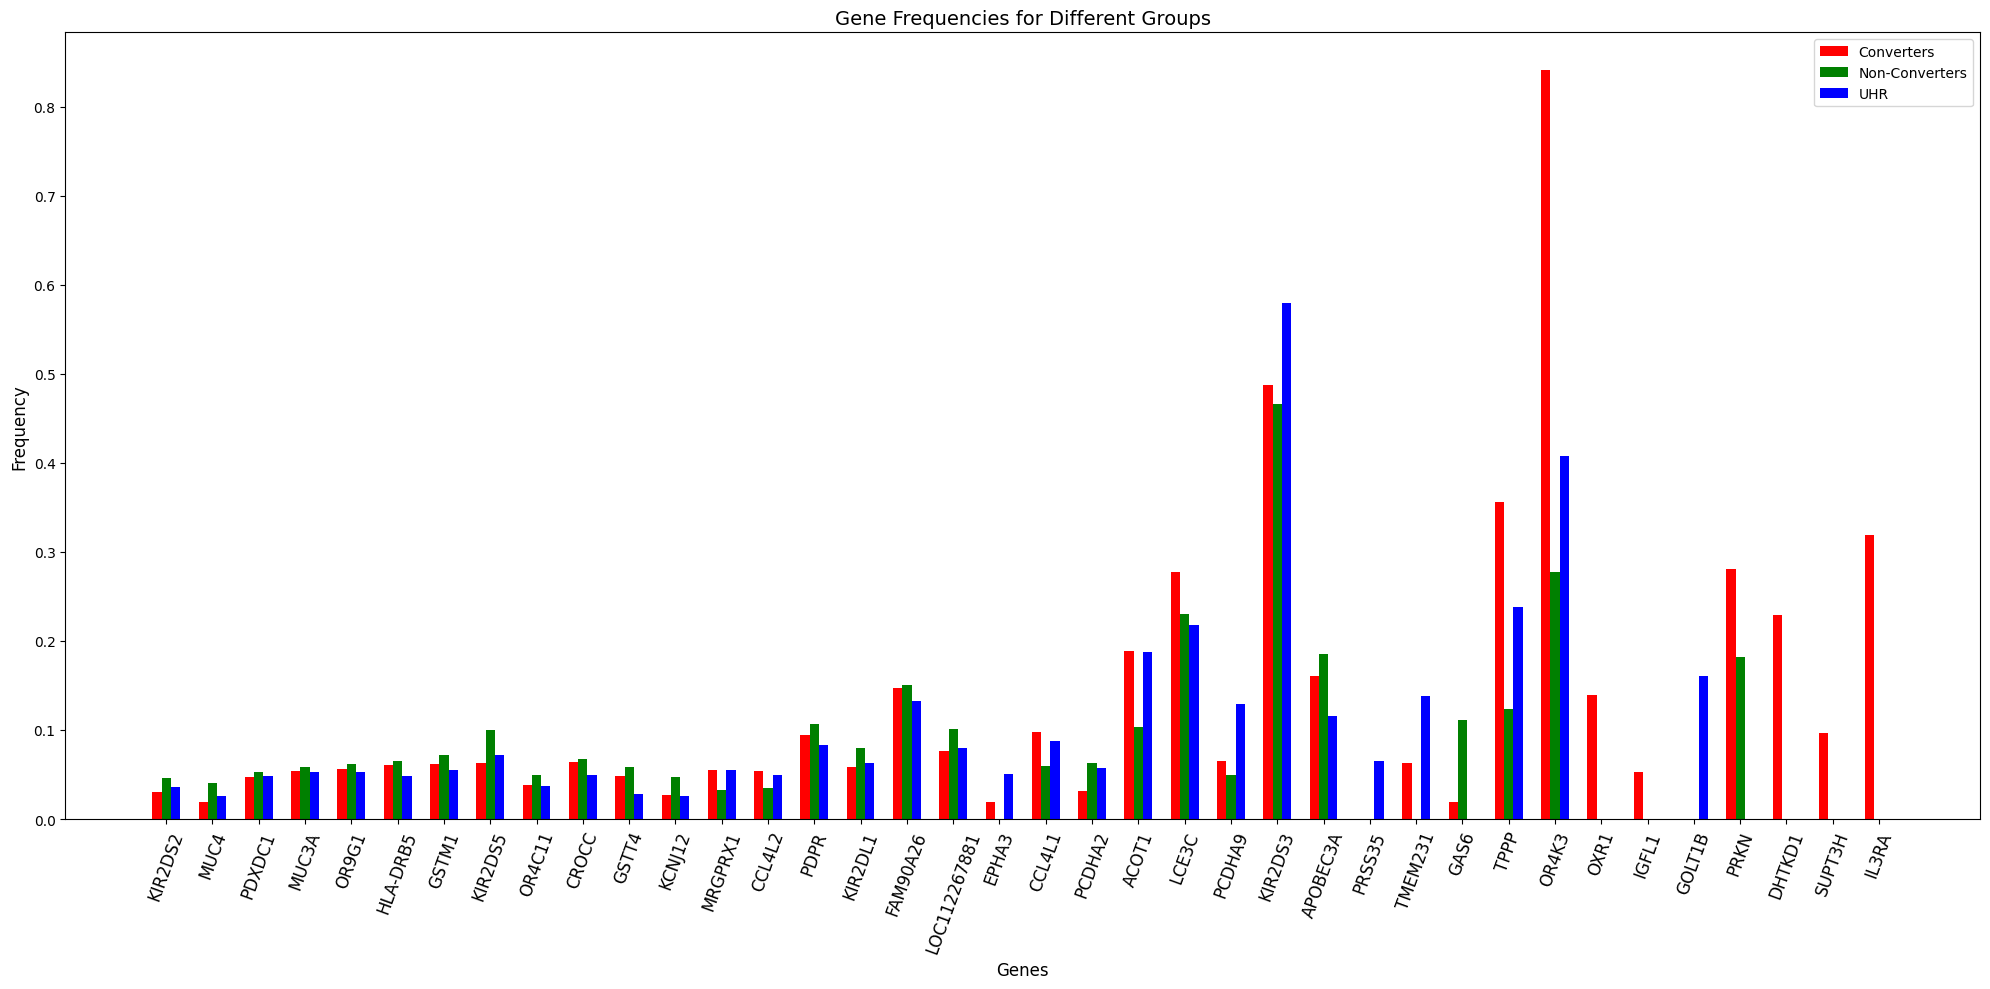

In [144]:
threshold = 0.04

filtered_df = df_contig[(df_contig['converters'] > threshold) |
                        (df_contig['non_converters'] > threshold) |
                        (df_contig['uhr'] > threshold)]

num_genes = len(filtered_df)
x_positions = range(num_genes)
bar_width = 0.2 

plt.figure(figsize=(20, 10))

plt.bar(x_positions, filtered_df['converters'], label='Converters', width=bar_width, color='red', align='center')
plt.bar([x + bar_width for x in x_positions], filtered_df['non_converters'], label='Non-Converters', width=bar_width, color='green', align='center')
plt.bar([x + 2 * bar_width for x in x_positions], filtered_df['uhr'], label='UHR', width=bar_width, color='blue', align='center')

plt.xticks([x + bar_width for x in x_positions], filtered_df.index, rotation=70, fontsize=12)  
plt.xlabel('Genes', fontsize=12) 
plt.ylabel('Frequency', fontsize=12) 
plt.title('Gene Frequencies for Different Groups', fontsize=14) 
plt.legend()

plt.tight_layout() 
plt.show()


In [159]:
from scipy.stats import fisher_exact

total_converters = df_contig['converters'].sum()
total_non_converters = df_contig['non_converters'].sum()

p_values = []

for index, row in df_contig.iterrows():
    contingency_table = [[row['converters'], row['non_converters']],
                          [total_converters - row['converters'], total_non_converters - row['non_converters']]]
    _, p_value = fisher_exact(contingency_table)
    p_values.append(p_value)

df_contig['p_value'] = p_values

alpha = 0.05
significant_genes = df_contig[df_contig['p_value'] < alpha]
print(significant_genes)


            converters  non_converters  uhr   p_value
TAS2R30             24               3    0  0.026759
EPHX4                0               1    0  0.024186
BRDT                 0               1    0  0.024186
GMNC                 0               1    0  0.024186
PABPC4L              0               1    0  0.024186
BTBD8                0               1    0  0.024186
CNR2                 0               1    0  0.024186
ORM2                 0               1    0  0.024186
MTMR3                0               1    0  0.024186
CDKN2AIPNL           0               1    0  0.024186
AKNA                 0               1    0  0.024186
RAD51B               0               1    0  0.024186
BCAS1               29               3    4  0.041551
SETSIP               0               1    0  0.024186
TGFBR3               0               1    0  0.024186
MTRES1               0               1    0  0.024186
ZNF678               0               1    0  0.024186
ORM1                 0      